## Lab 2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

### Imports

In [1]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

from copy import copy
import logging
from typing import Callable
import pandas as pd
import numpy as np
import geopy.distance

from icecream import ic
from itertools import combinations
from functools import partial

from algorithms import BaseSolver, HillClimber, HillClimberSimulatedAnnealing, EAStadyState
from utilities import plot_history, counter, get_console_logger

DEBUG:matplotlib:matplotlib data path: /home/svanni/Documents/university/computational_int/2024-2025/labs/CI2024_lab2/venv/lib64/python3.13/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/svanni/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/svanni/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/svanni/.cache/matplotlib/fontlist-v390.json


### Problem Set-up

In [2]:
CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
RNG = np.random.Generator(np.random.PCG64(len(CITIES)))
STEPS = 100_000
logger = get_console_logger(__name__, logging.INFO)
CITIES.head()

,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34


In [3]:
def total_tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))
    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

In [4]:
def greedy_solution():
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        logger.debug(
            f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
        )
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    logger.debug(
        f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
    )
    tsp.append(tsp[0])

    logger.info(f"result: Found a path of {len(tsp)-1} steps, total length {total_tsp_cost(tsp):.2f}km")

    tsp.pop()
    return tsp

In [5]:
def scrambe_mut(sol: np.ndarray, rnd: np.random.Generator):
    e1, e2 = rnd.choice(len(sol), size=2, replace=False)
    new_sol = sol.copy()
    new_sol[e2] = sol[e1]
    new_sol[e1] = sol[e2]
    return new_sol


def annealing_scramble_mut(sol: list[int], strenght: float, rnd: np.random.Generator):
    picked = False
    new_sol = copy(sol)
    while picked is False or (rnd.random() < strenght):
        picked = True
        e1, e2 = rnd.choice(len(sol), size=2, replace=False)
        swap = new_sol[e1]
        new_sol[e1] = new_sol[e2]
        new_sol[e2] = swap
    return new_sol


def new_annealing_scramble_mut(sol: list[int], strenght: float, rnd: np.random.Generator):
    new_sol = copy(sol)
    mask = rnd.random(len(sol)) < strenght
    idxs = np.nonzero(mask)
    if len(idxs) < 2:
        e1, e2 = rnd.choice(len(sol), size=2, replace=False)
        swap = new_sol[e1]
        new_sol[e1] = new_sol[e2]
        new_sol[e2] = swap
        return new_sol
    else:
        while len(idxs) > 1:
            e1, e2 = rnd.choice(len(idxs), size=2, replace=False)
            swap = new_sol[idxs[e1]]
            new_sol[idxs[e1]] = new_sol[idxs[e2]]
            new_sol[idxs[e2]] = swap
            idxs.pop(e1)
            idxs.pop(e2)
        return new_sol


def inverse_mut(sol: list[int], rnd: np.random.Generator):
    idx_e1, idx_e2 = rnd.choice(len(sol), size=2, replace=False)
    new_sol = copy(sol)
    if idx_e1 > idx_e2:
        e1 = new_sol.pop(idx_e1)
        new_sol.insert(idx_e2 + 1, e1)
    else:
        e2 = new_sol.pop(idx_e2)
        new_sol.insert(idx_e1 + 1, e2)
    return new_sol

In [6]:
@counter
def fitness(sol: list[int]):
    sol.append(sol[0])
    cost = total_tsp_cost(sol)
    sol.pop()
    return cost

In [7]:
init_sequential_sol = list(range(len(CITIES)))
init_greedy_solution = greedy_solution()

def run_experiment(
    algo: BaseSolver, steps: int, tweak: Callable, fitness: Callable, init_sol: list[int], *args, **kwargs
):
    algo_tweak = partial(tweak, rnd=RNG)
    ic(fitness(init_sol))
    fitness.num_calls = 0
    solver = algo(steps, algo_tweak, fitness, init_sol, *args, **kwargs)
    solver.solve()
    ic(solver.solution_fitness)
    ic(fitness.num_calls)
    plot_history(solver.history)

INFO - result: Found a path of 46 steps, total length 4436.03km
INFO:__main__:result: Found a path of 46 steps, total length 4436.03km


ic| fitness(init_sol): np.float64(4436.031769525158)
100%|██████████| 100000/100000 [00:01<00:00, 77081.41it/s]
ic| solver.solution_fitness: np.float64(4431.363767937217)
ic| fitness.num_calls: 100001


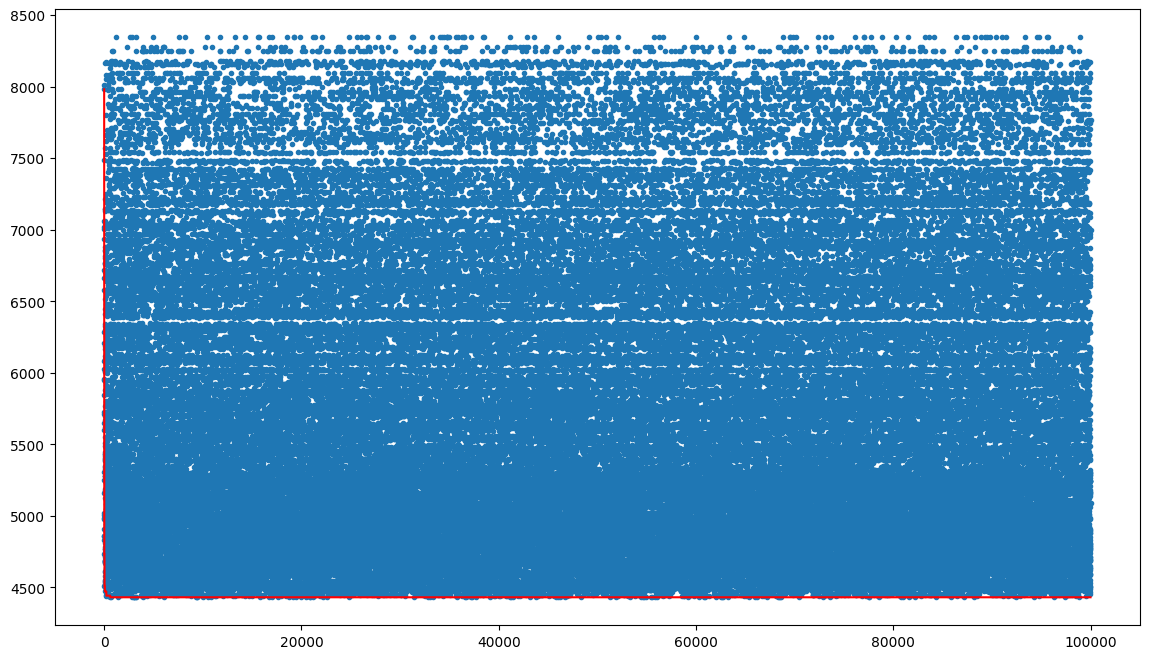

In [8]:
run_experiment(HillClimber, STEPS, scrambe_mut, fitness, init_greedy_solution)

ic| fitness(init_sol): np.float64(18732.852018630016)
100%|██████████| 100000/100000 [00:01<00:00, 68534.96it/s]
ic| solver.solution_fitness: np.float64(5588.926591510755)
ic| fitness.num_calls: 100001


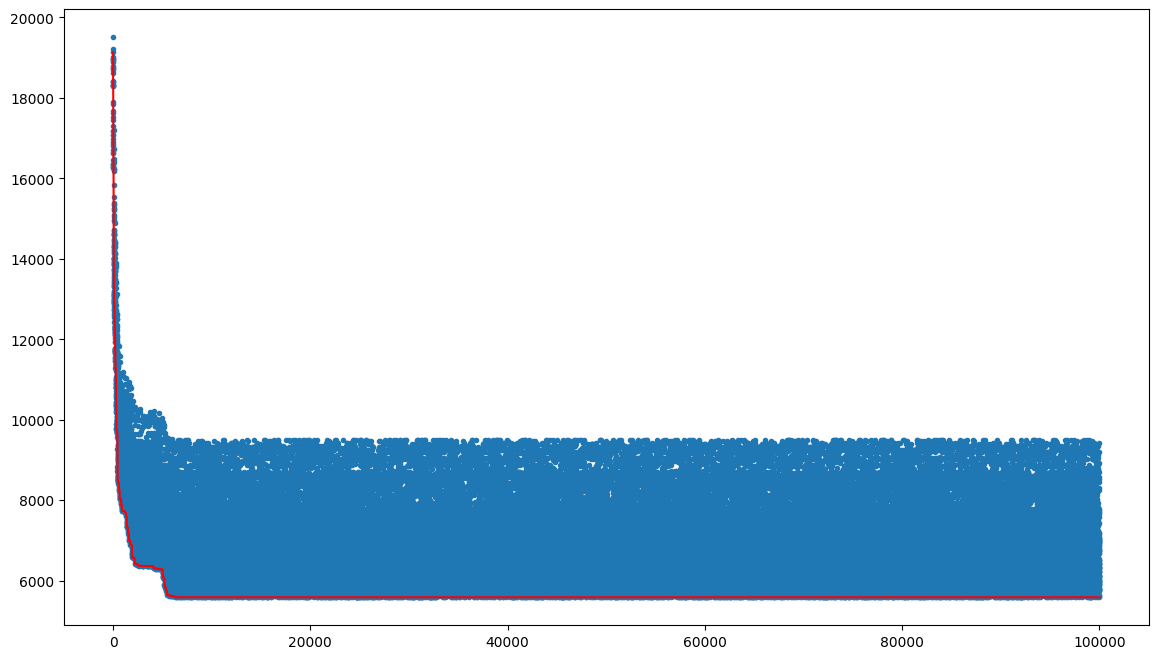

In [9]:
run_experiment(HillClimber, STEPS, scrambe_mut, fitness, init_sequential_sol)

ic| fitness(init_sol): np.float64(4436.031769525158)
100%|██████████| 100000/100000 [00:01<00:00, 74477.91it/s]
ic| solver.solution_fitness: np.float64(4431.363767937217)
ic| fitness.num_calls: 100001


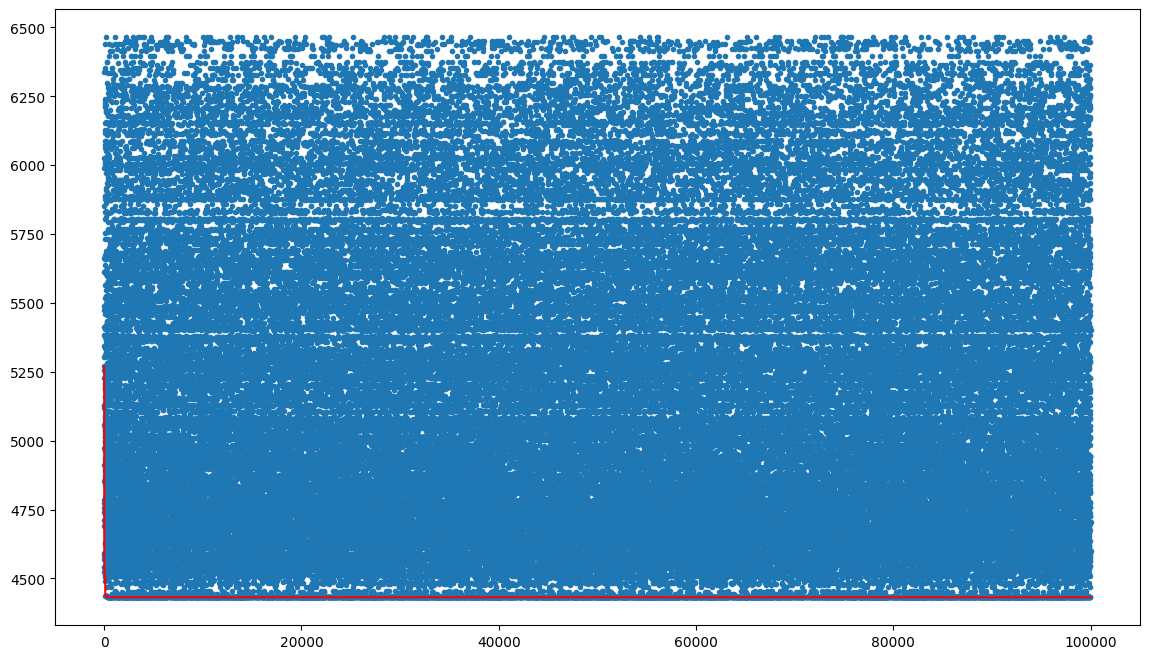

In [10]:
run_experiment(HillClimber, STEPS, inverse_mut, fitness, init_greedy_solution)

ic| fitness(init_sol): np.float64(18732.852018630016)
100%|██████████| 100000/100000 [00:01<00:00, 74826.63it/s]
ic| solver.solution_fitness: np.float64(6234.265002471207)
ic| fitness.num_calls: 100001


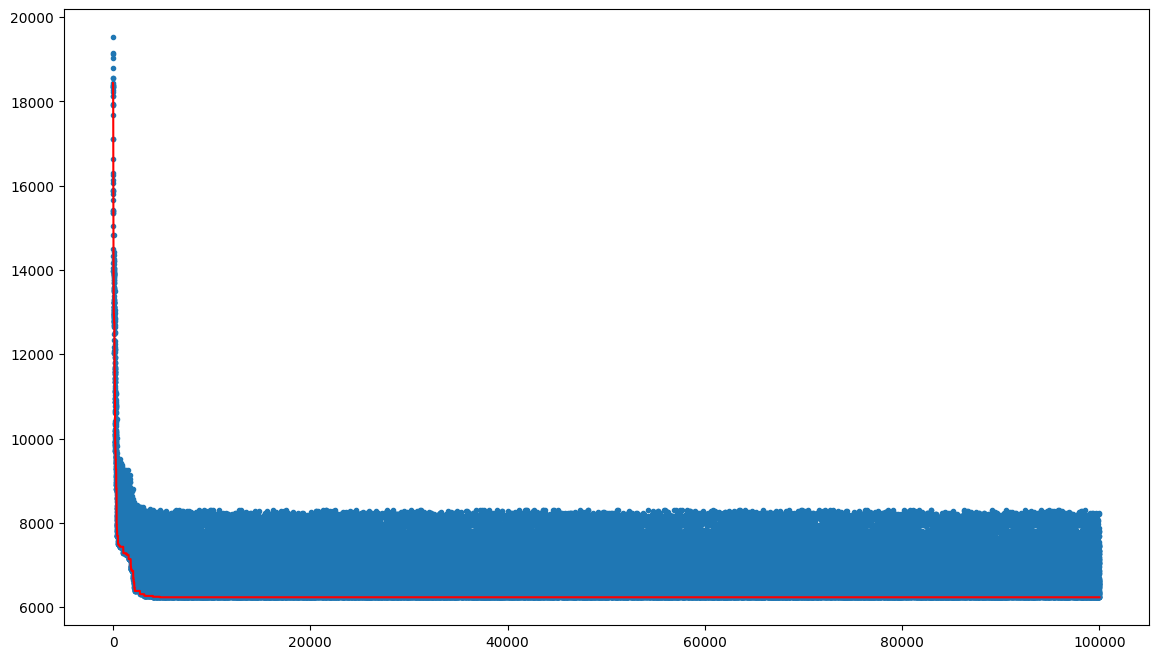

In [11]:
run_experiment(HillClimber, STEPS, inverse_mut, fitness, init_sequential_sol)

ic| fitness(init_sol): np.float64(4436.031769525158)
100%|██████████| 100000/100000 [00:01<00:00, 50942.63it/s]
ic| solver.solution_fitness: np.float64(4431.363767937217)
ic| fitness.num_calls: 100001


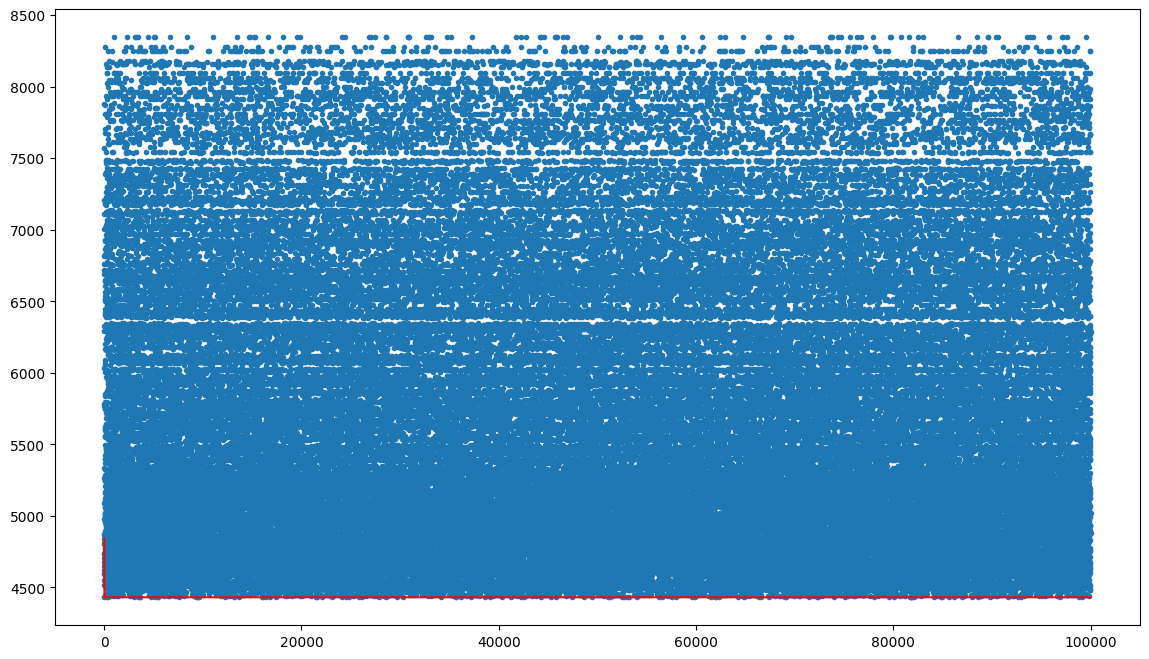

In [12]:
run_experiment(HillClimberSimulatedAnnealing, STEPS, new_annealing_scramble_mut, fitness, init_greedy_solution, strenght=0.9)

ic| fitness(init_sol): np.float64(18732.852018630016)
100%|██████████| 100000/100000 [00:01<00:00, 50480.85it/s]
ic| solver.solution_fitness: np.float64(5608.133142653828)
ic| fitness.num_calls: 100001


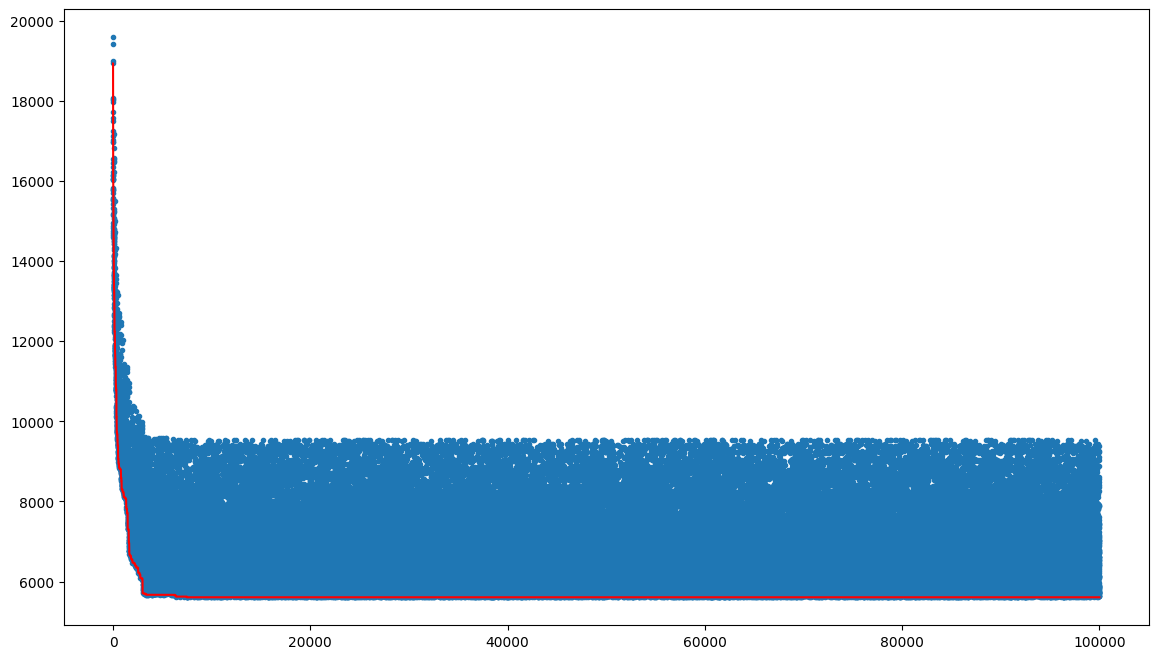

In [13]:
run_experiment(HillClimberSimulatedAnnealing, STEPS, new_annealing_scramble_mut, fitness, init_sequential_sol, strenght=0.9)

ic| fitness(init_sol): np.float64(18732.852018630016)
100%|██████████| 100000/100000 [00:29<00:00, 3365.18it/s]
ic| solver.solution_fitness: np.float64(5086.242023304279)
ic| fitness.num_calls: 2000030


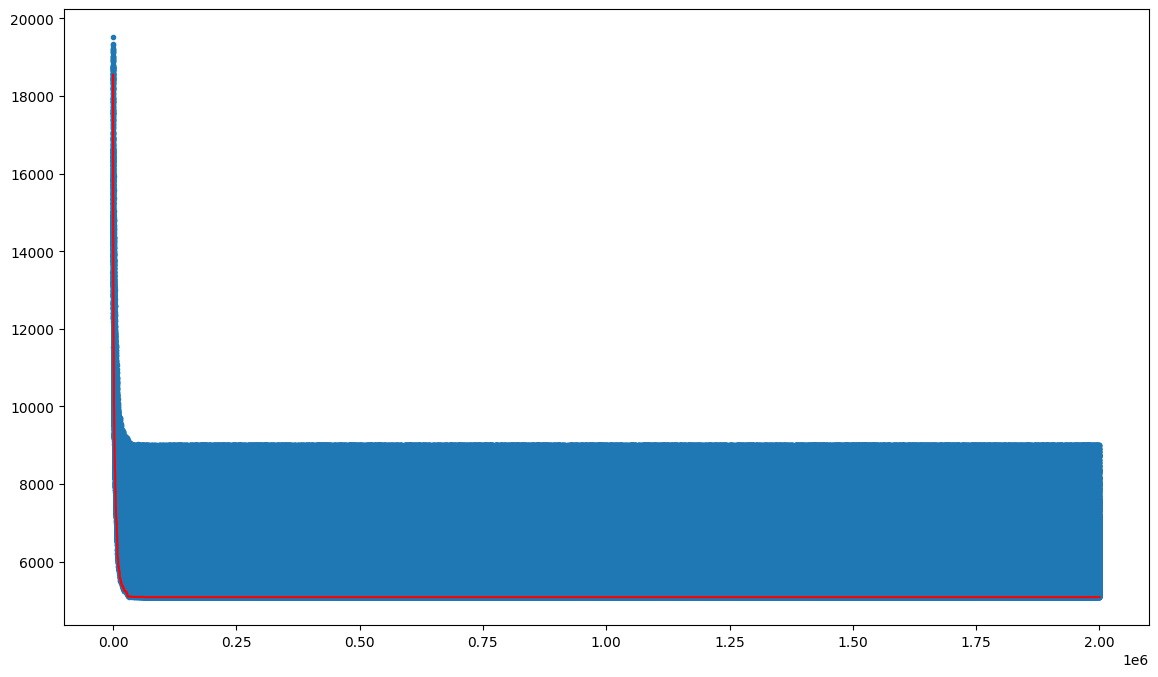

In [14]:
run_experiment(EAStadyState, STEPS, scrambe_mut, fitness, init_sequential_sol, population=30, offspring=20, rnd=RNG)

ic| fitness(init_sol): np.float64(4436.031769525158)
100%|██████████| 100000/100000 [00:29<00:00, 3434.26it/s]
ic| solver.solution_fitness: np.float64(4431.363767937217)
ic| fitness.num_calls: 2000030


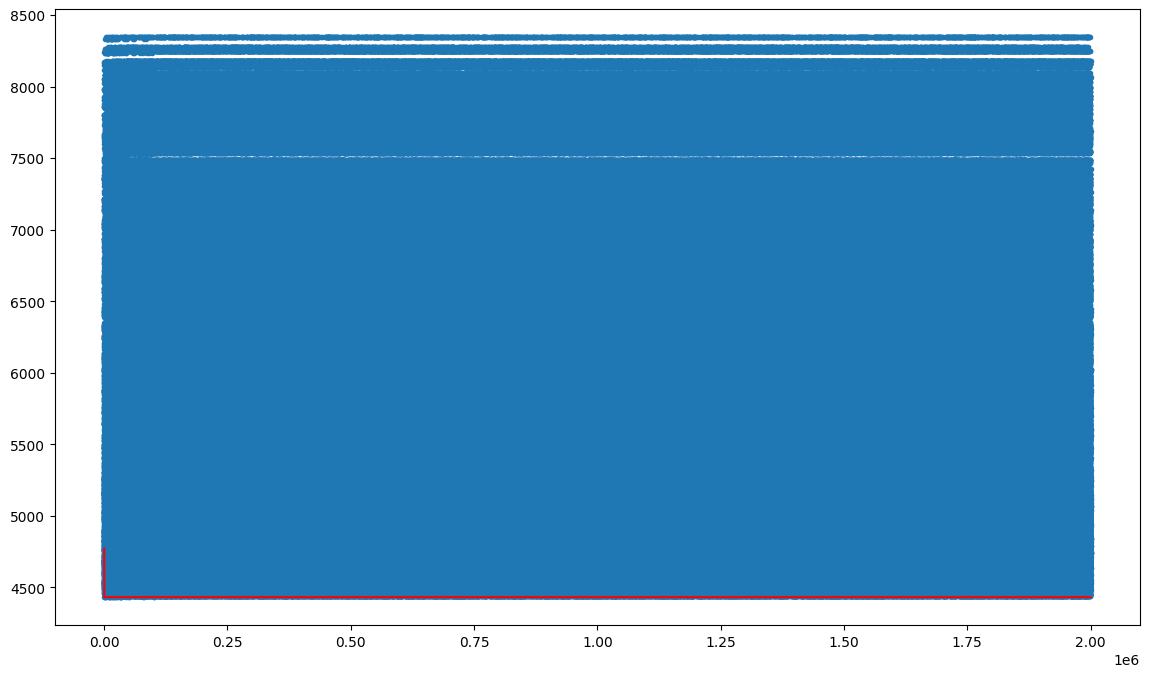

In [15]:
run_experiment(EAStadyState, STEPS, scrambe_mut, fitness, init_greedy_solution, population=30, offspring=20, rnd=RNG)